In [40]:
# # # # !pip install torch
# # # !pip install keras
# # # !pip install numpy pandas
# # !pip install torch
# # !pip install scikit_learn
# !pip install matplotlib
# !pip install fasttext

In [17]:
# !pip install tensorflow
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
# Specify GPU
device = torch.device("cuda")

In [22]:
# Load dataset
df = pd.read_csv('preprocessed.csv')
df.head()

,text,class,char_length,token_length
0,sex wife threatening suicide recently left wif...,1,364,54
1,weird affected compliment coming know girl fee...,0,76,11
2,finally thousand hear thousand bad year swear ...,0,66,10
3,need help help hard,1,33,6
4,ism lost hello adam sixteen 've struggling yea...,1,1376,193


# Do Splitting and get vocab first

In [23]:
# Split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['class'],
                                                                    random_state=0,
                                                                    test_size=0.2,
                                                                    stratify=df['class'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=0,
                                                                test_size=0.125,
                                                                stratify=temp_labels)

In [24]:
max_length = max([len(s.split()) for s in train_text])
max_length

5850

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
def tokenize_and_encode(text, max_length=62):
    # sequence encode
    encoded_docs = tokenizer.texts_to_sequences(text)
    # pad sequences
    padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    return padded_sequence

In [28]:
# Tokenize and encode sequences in all datasets
tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

In [29]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(tokens_train), torch.from_numpy(train_labels.to_numpy()))
val_data = TensorDataset(torch.from_numpy(tokens_val), torch.from_numpy(val_labels.to_numpy()))

# Sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# DataLoader
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

LSTM Architecture

In [30]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, 
                 embedding_dim, hidden_dim, n_layers, 
                 dropout_rate, pre_trained=False, embedding_vectors=None):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if pre_trained:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(embedding_vectors, True)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_rate, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3) # dropout_rate
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden
        

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Model Settings, eg: hyperparams, loss functions, etc

Note: We are still using FastText here

In [34]:
import random
def set_random_seed(seed):
    SEED = seed
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [35]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
set_random_seed(0)

In [36]:
# Instantiate the model w/ hyperparams
embedding_dim = 300
hidden_dim = 128
output_size = 1
n_layers = 2
dropout = 0.5

In [37]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# push to GPU
criterion = criterion.to(device)

In [38]:
# # !pip install fasttext
import fasttext
embedding = fasttext.load_model('cc.es.300.bin')

In [39]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab, embedding_dim):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, embedding_dim))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get_sentence_vector(word)

	return weight_matrix

In [40]:
# get vectors in the right order
embedding_vectors_fast = get_weight_matrix(embedding, tokenizer.word_index, 300)
embedding_vectors_fast = np.float32(embedding_vectors_fast)

In [41]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    # emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [43]:
model = LSTM(vocab_size, output_size, 300, hidden_dim, n_layers, dropout, 
                       pre_trained=True, embedding_vectors=embedding_vectors_fast)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_fast))

print("FastText pre trained embedding")
print(model)

print(f'Model has {count_parameters(model):,} trainable parameters')

FastText pre trained embedding
LSTM(
  (embedding): Embedding(75967, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model has 352,385 trainable parameters


# Model evaluation functions for reusability

In [44]:
def binary_accuracy(preds, labels):
    # convert output probabilities to predicted class (0 or 1)
    preds = torch.round(preds.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct = np.sum(correct)

    acc = num_correct/len(correct)

    return acc

In [45]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches of train data
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
#         if step % 50 == 0 and not step == 0:
#             print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        # batch = [r.to(device) for r in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        h = tuple([each.data for each in h])

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for current batch
        preds, h = model(inputs, h)
        
        # compute the loss between actual and predicted values
        loss = criterion(preds.squeeze(), labels.float())

        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()

        # clip the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        # compute accuracy
        acc = binary_accuracy(preds, labels)

        # add on to the total accuracy
        total_accuracy += acc.item()

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # compute the training acc of the epoch
    avg_acc = total_accuracy / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss, accuracy and predictions
    return avg_loss, avg_acc, total_preds

In [46]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers

    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
#         if step % 100 == 0 and not step == 0:
#             print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        # batch = [t.to(device) for t in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        val_h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        val_h = tuple([each.data for each in val_h])

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds, val_h = model(inputs, val_h)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds.squeeze(), labels.float())

            total_loss += loss.item()

            acc = binary_accuracy(preds, labels)

            total_accuracy += acc.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # compute the validation acc of the epoch
    avg_acc = total_accuracy / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds

# Model preparation, training, evaluation (1)

In [128]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5


set_random_seed(0)

In [129]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys.pt'

In [130]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change+1,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10: #terminate after >10
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.217
Validation Loss: 0.215

Training Accuracy: 0.917
Validation Accuracy: 0.919

 Epoch 2 / 30

Evaluating...
No improvement

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.217
Validation Loss: 0.213

Training Accuracy: 0.917
Validation Accuracy: 0.920

 Epoch 4 / 30

Evaluating...
No improvement

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.215
Validation Loss: 0.212

Training Accuracy: 0.917
Validation Accuracy: 0.920

 Epoch 6 / 30

Evaluating...
No improvement

 Epoch 7 / 30

Evaluating...
Improved

Training Loss: 0.214
Validation Loss: 0.211

Training Accuracy: 0.918
Validation Accuracy: 0.920

 Epoch 8 / 30

Evaluating...
No improvement

 Epoch 9 / 30

Evaluating...
Improved

Training Loss: 0.213
Validation Loss: 0.211

Training Accuracy: 0.919
Validation Accuracy: 0.921

 Epoch 10 / 30

Evaluating...
Improved

Training Loss: 0.213
Validation Loss: 0.210

Training Accuracy: 0.919
Validation Accuracy: 0.9

In [131]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (1)

In [132]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [133]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [134]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9306    0.9107    0.9205      2899
           1     0.9126    0.9321    0.9222      2901

    accuracy                         0.9214      5800
   macro avg     0.9216    0.9214    0.9214      5800
weighted avg     0.9216    0.9214    0.9214      5800



In [135]:
model_1_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_1_test_precision_score = precision_score(test_labels, total_preds)
model_1_test_recall_score = recall_score(test_labels, total_preds)
model_1_test_f1_score = f1_score(test_labels, total_preds)

In [136]:
print(model_1_test_accuracy_score)
print(model_1_test_precision_score)
print(model_1_test_recall_score)
print(model_1_test_f1_score)

0.9213793103448276
0.912588592642592
0.932092381937263
0.922237380627558


In [137]:
model1_train_accuracies = model_train_accuracies
model1_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (2)

In [138]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
set_random_seed(0)

In [139]:
# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_2.pt'

In [140]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change+1,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.197
Validation Loss: 0.198

Training Accuracy: 0.925
Validation Accuracy: 0.926

 Epoch 2 / 30

Evaluating...
No improvement

 Epoch 3 / 30

Evaluating...
No improvement

 Epoch 4 / 30

Evaluating...
No improvement

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.196
Validation Loss: 0.198

Training Accuracy: 0.925
Validation Accuracy: 0.926

 Epoch 6 / 30

Evaluating...
No improvement

 Epoch 7 / 30

Evaluating...
No improvement

 Epoch 8 / 30

Evaluating...
No improvement

 Epoch 9 / 30

Evaluating...
No improvement

 Epoch 10 / 30

Evaluating...
No improvement

Evaluating...
No improvement after 6 times

Evaluating...
No improvement after 7 times

Evaluating...
Improved

Training Loss: 0.196
Validation Loss: 0.198

Training Accuracy: 0.926
Validation Accuracy: 0.926

 Epoch 14 / 30

Evaluating...
Improved

Training Loss: 0.196
Validation Loss: 0.198

Training Accuracy: 0.926
Validation Accuracy: 0.926

 Epoch 15 / 30



In [141]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (2)

In [142]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [143]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [144]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9291    0.9138    0.9214      2899
           1     0.9152    0.9304    0.9227      2901

    accuracy                         0.9221      5800
   macro avg     0.9222    0.9221    0.9221      5800
weighted avg     0.9222    0.9221    0.9221      5800



In [145]:
model_2_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_2_test_precision_score = precision_score(test_labels, total_preds)
model_2_test_recall_score = recall_score(test_labels, total_preds)
model_2_test_f1_score = f1_score(test_labels, total_preds)

In [146]:
print(model_2_test_accuracy_score)
print(model_2_test_precision_score)
print(model_2_test_recall_score)
print(model_2_test_f1_score)

0.9220689655172414
0.915225500169549
0.9303688383316098
0.9227350427350426


In [147]:
model2_train_accuracies = model_train_accuracies
model2_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (3)

In [148]:
# Define the loss function
criterion = nn.BCELoss()
# push to GPU
criterion = criterion.to(device)

In [149]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
set_random_seed(0)

In [150]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_3.pt'

In [151]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.199
Validation Loss: 0.201

Training Accuracy: 0.924
Validation Accuracy: 0.924

 Epoch 2 / 30

Evaluating...
No improvement

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.197
Validation Loss: 0.197

Training Accuracy: 0.925
Validation Accuracy: 0.926

 Epoch 4 / 30

Evaluating...
No improvement

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.195
Validation Loss: 0.195

Training Accuracy: 0.926
Validation Accuracy: 0.926

 Epoch 6 / 30

Evaluating...
No improvement

 Epoch 7 / 30

Evaluating...
Improved

Training Loss: 0.194
Validation Loss: 0.194

Training Accuracy: 0.926
Validation Accuracy: 0.927

 Epoch 8 / 30

Evaluating...
No improvement

 Epoch 9 / 30

Evaluating...
No improvement

 Epoch 10 / 30

Evaluating...
Improved

Training Loss: 0.192
Validation Loss: 0.194

Training Accuracy: 0.928
Validation Accuracy: 0.928

 Epoch 11 / 30

Evaluating...
Improved

Training Loss: 0.192
Validation Loss: 0.193

Tra

In [152]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (3)

In [153]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [154]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [155]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9303    0.9207    0.9255      2899
           1     0.9215    0.9311    0.9263      2901

    accuracy                         0.9259      5800
   macro avg     0.9259    0.9259    0.9259      5800
weighted avg     0.9259    0.9259    0.9259      5800



In [156]:
model_3_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_3_test_precision_score = precision_score(test_labels, total_preds)
model_3_test_recall_score = recall_score(test_labels, total_preds)
model_3_test_f1_score = f1_score(test_labels, total_preds)

In [157]:
print(model_3_test_accuracy_score)
print(model_3_test_precision_score)
print(model_3_test_recall_score)
print(model_3_test_f1_score)

0.9258620689655173
0.9215284885704538
0.931058255773871
0.9262688614540465


In [158]:
model3_train_accuracies = model_train_accuracies
model3_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (4)

In [159]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
set_random_seed(0)

In [160]:
# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_4.pt'

In [161]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.179
Validation Loss: 0.186

Training Accuracy: 0.933
Validation Accuracy: 0.930

 Epoch 2 / 30

Evaluating...
No improvement

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.179
Validation Loss: 0.186

Training Accuracy: 0.933
Validation Accuracy: 0.930

 Epoch 4 / 30

Evaluating...
No improvement

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.179
Validation Loss: 0.186

Training Accuracy: 0.933
Validation Accuracy: 0.931

 Epoch 6 / 30

Evaluating...
No improvement

 Epoch 7 / 30

Evaluating...
Improved

Training Loss: 0.179
Validation Loss: 0.186

Training Accuracy: 0.933
Validation Accuracy: 0.930

 Epoch 8 / 30

Evaluating...
No improvement

 Epoch 9 / 30

Evaluating...
No improvement

 Epoch 10 / 30

Evaluating...
No improvement

 Epoch 11 / 30

Evaluating...
No improvement

 Epoch 12 / 30

Evaluating...
No improvement

Evaluating...
Improved

Training Loss: 0.178
Validation Loss: 0.186

Training Accuracy: 

In [162]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (4)

In [163]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [164]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [165]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9325    0.9193    0.9258      2899
           1     0.9205    0.9335    0.9269      2901

    accuracy                         0.9264      5800
   macro avg     0.9265    0.9264    0.9264      5800
weighted avg     0.9265    0.9264    0.9264      5800



In [166]:
model_4_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_4_test_precision_score = precision_score(test_labels, total_preds)
model_4_test_recall_score = recall_score(test_labels, total_preds)
model_4_test_f1_score = f1_score(test_labels, total_preds)

In [167]:
print(model_4_test_accuracy_score)
print(model_4_test_precision_score)
print(model_4_test_recall_score)
print(model_4_test_f1_score)

0.9263793103448276
0.920462270564242
0.9334712168217856
0.926921102173541


In [168]:
model4_train_accuracies = model_train_accuracies
model4_valid_accuracies = model_valid_accuracies

# Comparison

In [169]:
# !pip install prettytable

In [170]:
from prettytable import PrettyTable

In [171]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['Adam Optimizer with BCEWithLogitsLoss', 
               format(model_1_test_accuracy_score, '.4f'), 
               format(model_1_test_precision_score, '.4f'), 
               format(model_1_test_recall_score, '.4f'), 
               format(model_1_test_f1_score, '.4f')])

table.add_row(['SGD Optimizer with BCEWithLogitsLoss', 
               format(model_2_test_accuracy_score, '.4f'), 
               format(model_2_test_precision_score, '.4f'), 
               format(model_2_test_recall_score, '.4f'), 
               format(model_2_test_f1_score, '.4f')])

table.add_row(['Adam Optimizer with BCELoss', 
               format(model_3_test_accuracy_score, '.4f'), 
               format(model_3_test_precision_score, '.4f'), 
               format(model_3_test_recall_score, '.4f'), 
               format(model_3_test_f1_score, '.4f')])

table.add_row(['SGD Optimizer with BCELoss', 
               format(model_4_test_accuracy_score, '.4f'), 
               format(model_4_test_precision_score, '.4f'), 
               format(model_4_test_recall_score, '.4f'), 
               format(model_4_test_f1_score, '.4f')])

print(table)

+---------------------------------------+----------+-----------+--------+----------+
|                 Model                 | Accuracy | Precision | Recall | F1 Score |
+---------------------------------------+----------+-----------+--------+----------+
| Adam Optimizer with BCEWithLogitsLoss |  0.9214  |   0.9126  | 0.9321 |  0.9222  |
|  SGD Optimizer with BCEWithLogitsLoss |  0.9221  |   0.9152  | 0.9304 |  0.9227  |
|      Adam Optimizer with BCELoss      |  0.9259  |   0.9215  | 0.9311 |  0.9263  |
|       SGD Optimizer with BCELoss      |  0.9264  |   0.9205  | 0.9335 |  0.9269  |
+---------------------------------------+----------+-----------+--------+----------+


Since we are interested in Recall and F1: <Br> <b>
SGD Optimizer with BCELoss is the best for recall at 0.9335 and also has the highest F1 at 0.9269 <br>
SGD Optimizer with BCELoss would be the'best' here.

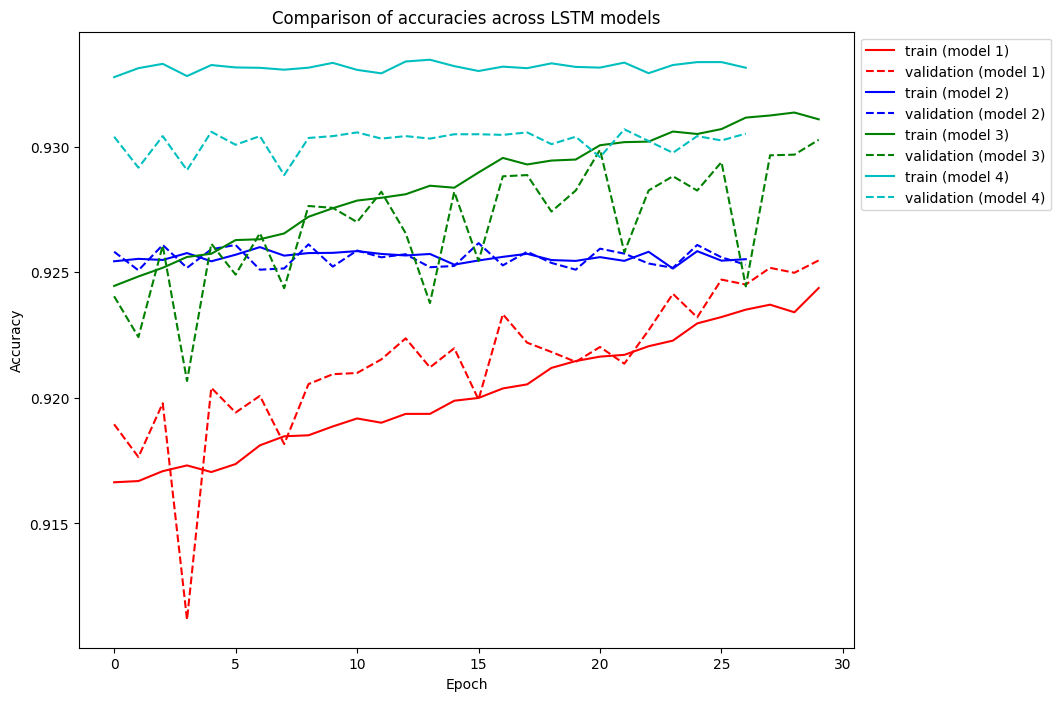

In [172]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(model1_train_accuracies, "r-")
plt.plot(model1_valid_accuracies, "r--")
plt.plot(model2_train_accuracies, "b-")
plt.plot(model2_valid_accuracies, "b--")
plt.plot(model3_train_accuracies, "g-")
plt.plot(model3_valid_accuracies, "g--")
plt.plot(model4_train_accuracies, "c-")
plt.plot(model4_valid_accuracies, "c--")
plt.title('Comparison of accuracies across LSTM models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train (model 1)', 'validation (model 1)', 'train (model 2)', 'validation (model 2)', 'train (model 3)', 'validation (model 3)', 'train (model 4)', 'validation (model 4)'], 
           bbox_to_anchor=(1, 1))
           #loc='upper left')
plt.show()